In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import yaml

from tqdm.notebook import tqdm

import pickle


In [2]:
from spine.utils.tracking import get_track_segments
from spine.utils.mcs import mcs_angles


In [3]:
from spine.driver import Driver


In [4]:
cfg_txt = '''
base:
  verbosity: warning
io:
  reader:
    name: hdf5
    file_keys: DATA_PATH
    skip_unknown_attrs: true
    
# Build reconstruction output representations
build:
  mode: both
  units: cm
  fragments: false
  particles: true
  interactions: true
'''


In [5]:
# downloaded from /pnfs/sbnd/persistent/users/mueller/MCP2025B/full_hdf5_test_files/mc5e18/*.h5
#DATA_FILES = os.listdir('/nevis/riverside/data/leehagaman/spine/mc5e18')
DATA_FILES = os.listdir('/nevis/riverside/data/leehagaman/spine/highEmuon/h5s')

log_file_location = '/nevis/houston/home/leehagaman/spine/mcs_studies/logs'

for file in os.listdir(log_file_location):
    os.remove(f'{log_file_location}/{file}')

num_files = 987

print(f"loading {num_files} / {len(DATA_FILES)} files")

true_contained = []
reco_contained = []
true_primary = []
reco_primary = []
true_start_point = []
reco_start_point = []
true_start_dir = []
reco_start_dir = []
truth_ke = []
reco_ke = []
reco_mcs_ke = []
reco_csda_ke = []
reco_calo_ke = []

reco_segment_dirs = []
reco_segment_angles = []
reco_segment_lengths = []
true_segment_dirs = []
true_segment_angles = []
true_segment_lengths = []

files = []
entries = []
for file_i, DATA_FILE in tqdm(enumerate(DATA_FILES[:num_files]), total=num_files):

    #DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/mc5e18/{DATA_FILE}'
    #DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/sbnd_medium_spine.h5'
    DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/highEmuon/h5s/{DATA_FILE}'

    disk_usage_MB = os.path.getsize(DATA_PATH) / (1024*1024)
    if disk_usage_MB < 0.1:
        print(f"skipping {DATA_FILE} because it is too small, {disk_usage_MB:.2f} MB")
        continue

    cfg = yaml.safe_load(cfg_txt.replace('DATA_PATH', DATA_PATH))
    driver = Driver(cfg)

    for ENTRY in range(len(driver)):
        data = driver.process(entry=ENTRY)

        for true_particle, reco_particle in data['particle_matches_t2r']:


            if abs(true_particle.pdg_code) != 13: # non-muon
                continue

            if not true_particle.is_matched: # no reco match
                continue

            reco_points = reco_particle.points
            true_points = true_particle.points

            curr_reco_segment_clusts, curr_reco_segment_dirs, curr_reco_segment_lengths = get_track_segments(reco_points, 14)
            curr_reco_segment_angles = mcs_angles(curr_reco_segment_dirs)
            reco_segment_dirs.append(curr_reco_segment_dirs)
            reco_segment_angles.append(curr_reco_segment_angles)
            reco_segment_lengths.append(curr_reco_segment_lengths)

            curr_true_segment_clusts, curr_true_segment_dirs, curr_true_segment_lengths = get_track_segments(true_points, 14)
            curr_true_segment_angles = mcs_angles(curr_true_segment_dirs)
            true_segment_dirs.append(curr_true_segment_dirs)
            true_segment_angles.append(curr_true_segment_angles)
            true_segment_lengths.append(curr_true_segment_lengths)
            true_contained.append(true_particle.is_contained)
            reco_contained.append(reco_particle.is_contained)
            
            true_primary.append(true_particle.is_primary)
            reco_primary.append(reco_particle.is_primary)

            true_start_point.append(true_particle.start_point)
            reco_start_point.append(reco_particle.start_point)

            true_start_dir.append(true_particle.start_dir)
            reco_start_dir.append(reco_particle.start_dir)

            truth_ke.append(true_particle.ke)
            reco_ke.append(reco_particle.ke)
            reco_mcs_ke.append(reco_particle.mcs_ke)
            reco_csda_ke.append(reco_particle.csda_ke)
            reco_calo_ke.append(reco_particle.calo_ke)

            files.append(DATA_FILE)
            entries.append(ENTRY)


loading 987 / 987 files


  0%|          | 0/987 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame({
    'file': files,
    'entry': entries,
    'true_contained': true_contained,
    'reco_contained': reco_contained,
    'true_primary': true_primary,
    'reco_primary': reco_primary,
    'true_start_point': true_start_point,
    'reco_start_point': reco_start_point,
    'true_start_dir': true_start_dir,
    'reco_start_dir': reco_start_dir,
    'reco_segment_lengths': reco_segment_lengths,
    'true_segment_lengths': true_segment_lengths,
    'truth_ke': truth_ke,
    'reco_ke': reco_ke,
    'reco_mcs_ke': reco_mcs_ke,
    'reco_csda_ke': reco_csda_ke,
    'reco_calo_ke': reco_calo_ke,
    'reco_segment_dirs': reco_segment_dirs,
    'reco_segment_angles': reco_segment_angles,
    'true_segment_dirs': true_segment_dirs,
    'true_segment_angles': true_segment_angles,
    })
df


,file,entry,true_contained,reco_contained,true_primary,reco_primary,true_start_point,reco_start_point,true_start_dir,reco_start_dir,...,true_segment_lengths,truth_ke,reco_ke,reco_mcs_ke,reco_csda_ke,reco_calo_ke,reco_segment_dirs,reco_segment_angles,true_segment_dirs,true_segment_angles
0,larcv_mc_20250625_001746_870122_6b0a8860-e7b1-...,0,False,False,True,True,"[-179.55002, 154.04996, 4.25]","[-179.55002, 154.05002, 4.25]","[0.9803921, -0.0946992, 0.17281024]","[0.97912776, -0.097012796, 0.17859796]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",100003.293954,1687.969508,1687.969508,881.363691,806.482117,"[[0.97961074, -0.10647929, 0.17036697], [0.981...","[0.021087611, 0.029116387, 0.029398322, 0.0848...","[[0.97961074, -0.10647929, 0.17036697], [0.981...","[0.021087611, 0.029116387, 0.029398322, 0.0848..."
1,larcv_mc_20250625_001746_870122_6b0a8860-e7b1-...,1,False,False,True,True,"[-23.850006, -109.350006, 10.25]","[-23.549988, -109.65001, 10.550003]","[0.36290038, 0.8886414, 0.28039205]","[0.35591567, 0.89514333, 0.2684072]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",99998.400565,1344.491911,1344.491911,789.721672,756.182190,"[[0.36064085, 0.89099973, 0.2757856], [0.34594...","[0.04368991, 0.04362143, 0.009760467, 0.066657...","[[0.36064085, 0.89099973, 0.2757856], [0.34594...","[0.04368991, 0.04362143, 0.009760467, 0.066657..."
2,larcv_mc_20250625_001746_870122_6b0a8860-e7b1-...,2,False,False,True,True,"[-118.95001, -133.65, 288.35]","[-118.65001, -133.35, 288.05002]","[0.45009753, 0.8539569, -0.2610935]","[0.4489212, 0.85516113, -0.2591701]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",99998.370920,1200.705090,1200.705090,889.602994,895.886475,"[[-0.44925493, -0.85572535, 0.25671804], [-0.4...","[0.036955144, 0.04717792, 0.09439409, 0.049496...","[[-0.44925493, -0.85572535, 0.25671804], [-0.4...","[0.036955144, 0.04717792, 0.09439409, 0.144162..."
3,larcv_mc_20250625_001746_870122_6b0a8860-e7b1-...,3,False,False,True,True,"[78.149994, -22.049988, 104.15]","[78.149994, -22.350006, 104.450005]","[-0.05194928, 0.9894481, 0.13525437]","[-0.05109994, 0.9904631, 0.12795193]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",99993.690386,958.090138,958.090138,519.211888,602.352722,"[[-0.042360116, 0.99550366, 0.084723465], [-0....","[0.04936657, 0.021078696, 0.029910851, 0.03015...","[[-0.042360116, 0.99550366, 0.084723465], [-0....","[0.04936657, 0.030288853, 0.029927885, 0.04742..."
4,larcv_mc_20250625_001746_870122_6b0a8860-e7b1-...,4,False,False,True,True,"[105.45001, -23.850006, 27.94999]","[105.45001, -24.149994, 28.550003]","[-0.34560803, 0.84197015, 0.4142962]","[-0.3491744, 0.8463207, 0.40226677]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",99998.340844,99999.997355,99999.997355,607.546979,613.468689,"[[-0.3426835, 0.8567055, 0.38551757], [-0.3616...","[0.051813833, 0.06893533, 0.067090996, 0.01998...","[[-0.3426835, 0.8567055, 0.38551757], [-0.3616...","[0.051813833, 0.06893533, 0.067090996, 0.01998..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,larcv_mc_20250625_032107_664854_c77a4d57-764a-...,5,False,False,True,True,"[-29.850006, -21.450012, 471.95004]","[-29.850006, -21.450012, 471.95004]","[0.79990965, 0.24595162, -0.547405]","[0.80140793, 0.24432656, -0.5459394]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",100003.288966,1532.272540,1532.272540,656.135382,680.276733,"[[-0.80650437, -0.2122381, 0.55182034], [-0.80...","[0.048522297, 0.04173321, 0.08790839, 0.020563...","[[-0.80650437, -0.2122381, 0.55182034], [-0.80...","[0.048522297, 0.04173321, 0.08790839, 0.020563..."
9794,larcv_mc_20250625_032107_664854_c77a4d57-764a-...,6,False,False,True,True,"[24.149994, 137.55002, 504.95004]","[24.149994, 137.55002, 504.95004]","[-0.13083926, -0.9822789, -0.13419862]","[-0.14335513, -0.97902197, -0.1447941]",...,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",99993.685904,4264.691348,4264.691348,782.714407,

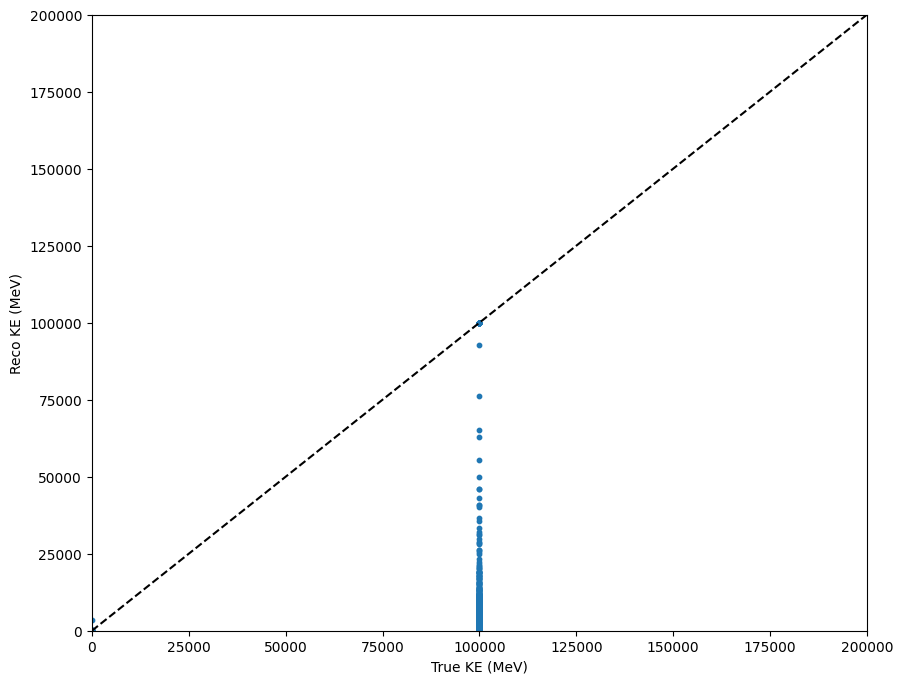

In [7]:
# plot reco energy vs true energy
plt.figure(figsize=(10, 8))
plt.scatter(df['truth_ke'], df['reco_ke'], s=10)
plt.plot([0, 200_000], [0, 200_000], 'k--')
plt.xlim(0, 200_000)
plt.ylim(0, 200_000)
plt.xlabel('True KE (MeV)')
plt.ylabel('Reco KE (MeV)')
plt.show()


In [8]:
with open('/nevis/houston/home/leehagaman/spine/mcs_studies/h5_highEmuon_with_segment_angles.pkl', 'wb') as f:
    pickle.dump(df, f)